In [1]:
# 权重衰减 通过函数与零的距离来衡量函数的复杂度 
# 缓解过拟合 限制特征 权重衰减,也别称之为L2正则化
''' 
如何精确地测量⼀个函数和零之间的距离？
⼀种简单的⽅法是通过线性函数 f(x) = w⊤x 中的权重向量
的某个范数来度量其复杂性，例如∥w∥2。要保证权重向量⽐较⼩
最常⽤⽅法是将其范数作为惩罚项加到最⼩化损失的问题中
将原来的训练⽬标最⼩化训练标签上的预测损失，
调整为最⼩化预测损失和惩罚项之和

现在，如果我们的权重向量增⻓的太⼤，
我们的学习算法可能会更集中于最⼩化权重范数∥w∥2
---------------------------------------------------------------
你可能会想知道为什么我们使⽤平⽅范数⽽不是标准范数（即欧⼏⾥得距离）？
我们这样做是为了便于计算。通过平⽅L2范数，我们去掉平⽅根，
留下权重向量每个分量的平⽅和。
这使得惩罚的导数很容易计算：导数的和等于和的导数

此外，你可能会问为什么我们⾸先使⽤L2范数，⽽不是L1范数。
事实上，这个选择在整个统计领域中都是有效的和受欢迎的。
L2正则化线性模型构成经典的岭回归（ridge regression）算法，
L1正则化线性回归是统计学中类似的基本模型，
通常被称为套索回归（lasso regression）。
使⽤L2范数的⼀个原因是它对权重向量的⼤分量施加了巨⼤的惩罚。
这使得我们的学习算法偏向于在⼤量特征上均匀分布权重的模型。
在实践中，这可能使它们对单个变量中的观测误差更为稳定。
相⽐之下，L1惩罚会导致模型将权重集中在⼀⼩部分特征上，
⽽将其他权重清除为零。这称为特征选择（feature selection），
这可能是其他场景下需要的
'''
# 高维线性回归 
%matplotlib inline 
import torch
from torch import nn
from d2l import torch as d2l


In [2]:
# 数据生成
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train) # 合成数据
''' 
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise.

    Defined in :numref:`sec_linear_scratch`"""
    X = d2l.normal(0, 1, (num_examples, len(w))) # 均值 方差 size
    y = d2l.matmul(X, w) + b
    y += d2l.normal(0, 0.01, y.shape)
    return X, d2l.reshape(y, (-1, 1))
'''
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [3]:
# 从零开始实现 只需将L2的平方惩罚加入到原始目标数据中
# 定义随机初始化模型函数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [4]:
# 定义L2范数惩罚
# 实现这⼀惩罚最⽅便的⽅法是对所有项求平⽅后并将它们求和
def l2_penalty(w): # penalty 惩罚
    return torch.sum(w.pow(2)) / 2 # w.pow(2) 返回w^2

In [7]:
# 定义训练代码实现
def train(lambd):
    w, b = init_params() # 参数初始化 w 正态0,1 b 0
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # 这里对net赋值lambda X: d2l.linreg(X, w, b)，
    # 是用到python匿名函数lambda [parameters]: expression。
    # 即调用net(X)就相当于调用d2l.linreg(X, w, b)
    # 匿名函数不需要return获取返回值，表达式本身结果就是返回值。
    # 匿名函数优点就是不需要起函数名
    # linreg linear regression model 线性回归模型 quared_loss 平方损失
    num_epochs, lr = 100, 0.003 # 迭代周期100 学习率0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs): 
        for X, y in train_iter: 
            # 增加了L2范数惩罚项，
            # ⼴播机制使l2_penalty(w)成为⼀个⻓度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w) # 损失+lambd*L2惩罚 L(w, b) + λ/2||w||^2
            l.sum().backward() 
            d2l.sgd([w, b], lr, batch_size) # 随机梯度下降 更新参数
        if (epoch + 1) % 5 == 0: # 用于可视化,每5个周期打印一次; add(self, x, y)
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss))) # 评估损失 训练集/测试集
    print('w的L2范数是：', torch.norm(w).item()) 
    # torch.norm(w) 求w的范数 norm 规范,基准(默认p=2,即L2范数)  .item() 返回张量元素的值


w的L2范数是： 12.610954284667969


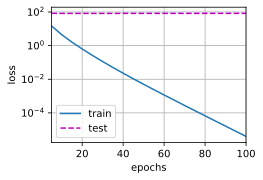

In [6]:
# 忽略正则化直接训练 使 lambd = 0  禁用权重衰减
# 训练误差减小,测试误差不变
train(lambd=0) 


w的L2范数是： 0.3422093689441681


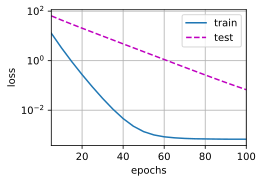

In [8]:
# 使用权重衰减
# 训练误差增大但测试误差减小
train(lambd=3)

In [11]:
# 简介实现 权重衰减集成于优化算法中,便于与任何损失函数结合使用
# 可在不增加任何额外计算开销的情况下向算法添加权重衰减
# 由于更新的权重衰减部分仅依赖每个参数的当前值,因此优化器必须至少接触每个参数一次
def train_concise(wd): # concise 简明的
    net = nn.Sequential(nn.Linear(num_inputs, 1)) # 容器  liner() 线性变换 linreg() 线性回归
    for param in net.parameters(): # 返回模块参数的迭代器,通常传递给优化进程
        param.data.normal_() # 数据正态初始化
    loss = nn.MSELoss(reduction='none') # mean squared error 均方误差损失
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr) # 随机梯度下降 直接在优化器中加入权重衰减
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad() # 梯度清零
            l = loss(net(X), y) # 损失计算
            l.mean().backward() # 反向传播
            trainer.step()      # 参数更新
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,(
                d2l.evaluate_loss(net, train_iter, loss),
                d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())


w的L2范数： 0.38969215750694275


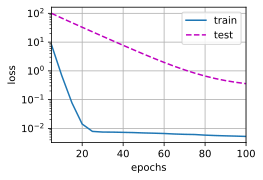

In [12]:
train_concise(3)

In [20]:
''' 
本书中默认使用简单的启发式方法,即在深层网络的所有层上应用权重衰减

⼩结
• 正则化是处理过拟合的常⽤⽅法：在训练集的损失函数中加⼊惩罚项，以降低学习到的模型的复杂度。
• 保持模型简单的⼀个特别的选择是使⽤L2惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。
• 权重衰减功能在深度学习框架的优化器中提供。
• 在同⼀训练代码实现中，不同的参数集可以有不同的更新⾏为
'''


' \n本书中默认使用简单的启发式方法,即在深层网络的所有层上应用权重衰减\n\n⼩结\n• 正则化是处理过拟合的常⽤⽅法：在训练集的损失函数中加⼊惩罚项，以降低学习到的模型的复杂度。\n• 保持模型简单的⼀个特别的选择是使⽤L2惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。\n• 权重衰减功能在深度学习框架的优化器中提供。\n• 在同⼀训练代码实现中，不同的参数集可以有不同的更新⾏为\n'